# Bias Detection and Fairness Evaluation

In this notebook, we will load our cleaned dataset, split it into training and testing sets, scale the features, and train a baseline model using Logistic Regression. We will then evaluate the model's performance and compute fairness metrics (Statistical Parity Difference and Disparate Impact) using AIF360.

Below, we first set up our environment by defining the project root and the path to our cleaned dataset.


In [7]:
import os
import sys
import pandas as pd
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Determine the project root so we can build absolute paths reliably.
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
# Note: In a notebook, you might prefer to use os.getcwd() instead.
# project_root = os.getcwd()
cleaned_csv_path = os.path.join(project_root, "data", "train_cleaned.csv")
print("Loading cleaned data from:", cleaned_csv_path)

# Check if the cleaned data file exists; if not, stop the notebook.
if not os.path.exists(cleaned_csv_path):
    sys.exit("Error: 'train_cleaned.csv' not found. Please run the data_cleaning.py script first.")

# Load the cleaned dataset.
df = pd.read_csv(cleaned_csv_path)
print("Cleaned data loaded. Shape:", df.shape)


Loading cleaned data from: /Users/stay-c/Desktop/AI_Fairness_Project/data/train_cleaned.csv
Cleaned data loaded. Shape: (32561, 15)


## Data Preparation

In this cell, we assume that our target column is named `income_binary`. We separate the features from the target, and then split the data into training and testing sets using a 70-30 split.


In [8]:
from sklearn.model_selection import train_test_split

# Verify that the target column 'income_binary' exists.
if 'income_binary' not in df.columns:
    sys.exit("Error: Expected target column 'income_binary' not found.")

# Separate features (X) from target (y).
X = df.drop(['income_binary'], axis=1)
y = df['income_binary']

# Split the data into training (70%) and testing (30%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Data split into training and testing sets.")


Data split into training and testing sets.


## Feature Scaling and Baseline Model Training

Standardizing features is important for many machine learning models. In this cell, we scale our features and then train a baseline Logistic Regression model on the training data. We'll evaluate the model's performance on the test set.


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Scale features using StandardScaler.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a baseline Logistic Regression model.
model = LogisticRegression(max_iter=2000)
model.fit(X_train_scaled, y_train)
pred_baseline = model.predict(X_test_scaled)

# Evaluate model performance.
acc = accuracy_score(y_test, pred_baseline)
print("Baseline Model Accuracy:", acc)
print("Baseline Classification Report:")
print(classification_report(y_test, pred_baseline))


Baseline Model Accuracy: 0.8258777766403931
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7455
           1       0.71      0.45      0.55      2314

    accuracy                           0.83      9769
   macro avg       0.78      0.70      0.72      9769
weighted avg       0.81      0.83      0.81      9769



## Fairness Evaluation

Next, we evaluate fairness by converting our test data into an AIF360 BinaryLabelDataset. We assume that our protected attribute is `sex` (with 1 for privileged, e.g., Male, and 0 for unprivileged, e.g., Female). We then compute key fairness metrics: Statistical Parity Difference and Disparate Impact.


In [10]:
# Ensure that the protected attribute 'sex' is present.
if 'sex' not in X.columns:
    sys.exit("Error: Protected attribute 'sex' not found in data.")

# Build a DataFrame for fairness evaluation with true and predicted labels.
X_test_df = pd.DataFrame(X_test, columns=X.columns)
X_test_df['true_label'] = y_test.values
X_test_df['pred_label'] = pred_baseline

# Convert the DataFrame to an AIF360 BinaryLabelDataset.
dataset_true = BinaryLabelDataset(df=X_test_df, label_names=['true_label'], protected_attribute_names=['sex'])
dataset_pred = dataset_true.copy()
dataset_pred.labels = X_test_df['pred_label'].values.reshape(-1, 1)

# Compute fairness metrics.
fair_metric = ClassificationMetric(
    dataset_true,
    dataset_pred,
    privileged_groups=[{'sex': 1}],    # Assuming 'sex' = 1 is privileged (e.g., Male)
    unprivileged_groups=[{'sex': 0}]   # Assuming 'sex' = 0 is unprivileged (e.g., Female)
)
print("Baseline Fairness Metrics:")
print("Statistical Parity Difference:", fair_metric.statistical_parity_difference())
print("Disparate Impact:", fair_metric.disparate_impact())


Baseline Fairness Metrics:
Statistical Parity Difference: -0.1754883749654449
Disparate Impact: 0.16342001686180982


## Visualization of Group-Level Predictions

This final cell visualizes the average positive prediction rate by group (protected attribute: 'sex'). This helps us see if there's a significant difference in predictions between the privileged and unprivileged groups.


Average positive prediction rate by group:
sex
0    0.034280
1    0.209769
Name: pred_label, dtype: float64


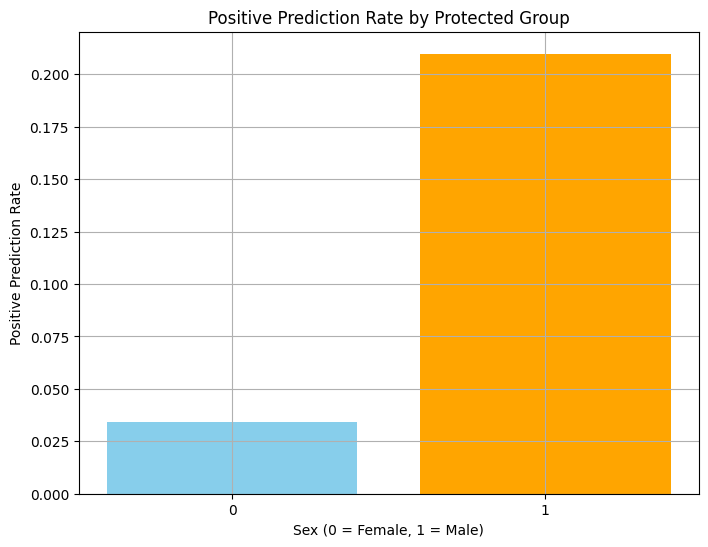

In [11]:
import matplotlib.pyplot as plt

# Calculate the average positive prediction rate by group.
grouped = X_test_df.groupby('sex')['pred_label'].mean()
print("Average positive prediction rate by group:")
print(grouped)

# Create a bar chart for visualization.
plt.figure(figsize=(8, 6))
plt.bar(grouped.index.astype(str), grouped.values, color=['skyblue', 'orange'])
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.ylabel('Positive Prediction Rate')
plt.title('Positive Prediction Rate by Protected Group')
plt.grid(True)
plt.show()
